In [8]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import collections
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight
import random

In [9]:
tf.random.set_seed(50)

In [10]:
dataset, info = tfds.load('eurosat', with_info=True, as_supervised=True)

# 1. Access the train split
full_ds = dataset['train']

# 2. CRITICAL: Shuffle first to mix classes, then take 5000
# We use a buffer size equal to the full dataset (27000) to ensure perfect shuffling
full_ds = full_ds.shuffle(27000, seed=50).take(5000)

# Update info for your print statements
num_examples = 5000 # Manually update this so your print below is correct
num_classes = info.features['label'].num_classes
class_names = info.features['label'].names
image_shape = info.features['image'].shape
image_dtype = info.features['image'].tf_dtype

print("===== EuroSAT Dataset Info (REDUCED) =====")
print(f"Number of examples: {num_examples}")
print(f"Number of classes: {num_classes}")
print(f"Class names: {class_names}")

===== EuroSAT Dataset Info (REDUCED) =====
Number of examples: 5000
Number of classes: 10
Class names: ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']


In [11]:
def resize_and_rescale(image, label, target=224):
    image = tf.image.resize(image, [target, target])    #resize images from 64×64 to 224×224
    image = tf.cast(image, tf.float32) / 255.0     #convert pixel type
    return image, label

In [12]:
full_ds = full_ds.map(resize_and_rescale)

In [13]:
num_examples = tf.data.experimental.cardinality(full_ds).numpy()

train_size = int(0.7 * num_examples)
val_size   = int(0.15 * num_examples)

# 70% train, 15% val, 15% test

train_ds = full_ds.take(train_size)
# Remaining 30%
remaining = full_ds.skip(train_size)

val_ds = remaining.take(val_size)

test_ds = remaining.skip(val_size)

# how many examples in each split
train_count = tf.data.experimental.cardinality(train_ds).numpy()
val_count   = tf.data.experimental.cardinality(val_ds).numpy()
test_count   = tf.data.experimental.cardinality(test_ds).numpy()
print(f"Train examples: {train_count}, Val examples: {val_count}, Test examples: {test_count}")

Train examples: 3500, Val examples: 750, Test examples: 750


In [14]:
# Inspect class counts (detect imbalance)
counts = collections.Counter() #dictionary-like object that counts occurrences of items
y_train_list = []


for _, lbl in tfds.as_numpy(train_ds):
    counts[int(lbl)] += 1
    y_train_list.append(int(lbl))

print("Per-class counts (train):")
for cls in sorted(counts.keys()):
    print(f"  class {cls}: {counts[cls]} images")

Per-class counts (train):
  class 0: 400 images
  class 1: 397 images
  class 2: 393 images
  class 3: 314 images
  class 4: 330 images
  class 5: 260 images
  class 6: 306 images
  class 7: 389 images
  class 8: 337 images
  class 9: 374 images


In [15]:
# no class imbalance, so we'll apply light augmentation just to
# improve model training and generalization and reduce overfitting

#minimal light augmentation

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
])

In [16]:
#apply augmentation to the training dataset only

train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True),y))

In [17]:
BATCH_SIZE = 4

train_ds = train_ds.shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_ds   = val_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_ds  = test_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [18]:
model_vgg = tf.keras.Sequential([
    # -------- Block 1 --------
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(224,224,3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2,2)),

    # -------- Block 2 --------
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2,2)),

    # -------- Block 3 --------
    tf.keras.layers.Conv2D(128, (3,3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2,2)),

    # -------- Block 4 --------
    tf.keras.layers.Conv2D(256, (3,3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(256, (3,3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(256, (3,3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(256, (3,3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2,2)),

    # -------- Block 5 --------
    tf.keras.layers.Conv2D(256, (3,3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(256, (3,3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(256, (3,3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(256, (3,3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2,2)),

    # -------- Classifier --------
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [19]:
model_vgg.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


In [20]:
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

history = model_vgg.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[early_stop]
)


Epoch 1/10
875/875 ━━━━━━━━━━━━━━━━━━━━ 102s 76ms/step - accuracy: 0.2693 - loss: 2.4089 - val_accuracy: 0.3147 - val_loss: 3.0724
Epoch 2/10
875/875 ━━━━━━━━━━━━━━━━━━━━ 74s 71ms/step - accuracy: 0.2899 - loss: 2.3007 - val_accuracy: 0.3267 - val_loss: 2.1866
Epoch 3/10
875/875 ━━━━━━━━━━━━━━━━━━━━ 74s 71ms/step - accuracy: 0.2902 - loss: 2.3557 - val_accuracy: 0.3813 - val_loss: 2.2616
Epoch 4/10
875/875 ━━━━━━━━━━━━━━━━━━━━ 73s 71ms/step - accuracy: 0.2736 - loss: 2.3300 - val_accuracy: 0.3000 - val_loss: 5.2915
Epoch 5/10
875/875 ━━━━━━━━━━━━━━━━━━━━ 73s 71ms/step - accuracy: 0.2655 - loss: 2.3477 - val_accuracy: 0.3547 - val_loss: 3.2860
Epoch 6/10
875/875 ━━━━━━━━━━━━━━━━━━━━ 73s 71ms/step - accuracy: 0.2690 - loss: 2.3541 - val_accuracy: 0.3280 - val_loss: 2.2731
Epoch 7/10
875/875 ━━━━━━━━━━━━━━━━━━━━ 73s 71ms/step - accuracy: 0.2590 - loss: 2.2767 - val_accuracy: 0.3920 - val_loss: 1.9705
Epoch 8/10
875/875 ━━━━━━━━━━━━━━━━━━━━ 73s 70ms/step - accuracy: 0.2839 - loss: 2.2093 -

In [21]:
# from tensorflow.keras import layers, models

# def VGG19_scratch(input_shape=(224, 224, 3), num_classes=10):
#     model = models.Sequential()

#     # Block 1
#     model.add(layers.Conv2D(64, (3,3), activation='relu', padding='same',
#                             input_shape=input_shape))
#     model.add(layers.Conv2D(64, (3,3), activation='relu', padding='same'))
#     model.add(layers.MaxPooling2D((2,2), strides=(2,2)))

#     # Block 2
#     model.add(layers.Conv2D(128, (3,3), activation='relu', padding='same'))
#     model.add(layers.Conv2D(128, (3,3), activation='relu', padding='same'))
#     model.add(layers.MaxPooling2D((2,2), strides=(2,2)))

#     # Block 3
#     model.add(layers.Conv2D(256, (3,3), activation='relu', padding='same'))
#     model.add(layers.Conv2D(256, (3,3), activation='relu', padding='same'))
#     model.add(layers.Conv2D(256, (3,3), activation='relu', padding='same'))
#     model.add(layers.Conv2D(256, (3,3), activation='relu', padding='same'))
#     model.add(layers.MaxPooling2D((2,2), strides=(2,2)))

#     # Block 4
#     model.add(layers.Conv2D(512, (3,3), activation='relu', padding='same'))
#     model.add(layers.Conv2D(512, (3,3), activation='relu', padding='same'))
#     model.add(layers.Conv2D(512, (3,3), activation='relu', padding='same'))
#     model.add(layers.Conv2D(512, (3,3), activation='relu', padding='same'))
#     model.add(layers.MaxPooling2D((2,2), strides=(2,2)))

#     # Block 5
#     model.add(layers.Conv2D(512, (3,3), activation='relu', padding='same'))
#     model.add(layers.Conv2D(512, (3,3), activation='relu', padding='same'))
#     model.add(layers.Conv2D(512, (3,3), activation='relu', padding='same'))
#     model.add(layers.Conv2D(512, (3,3), activation='relu', padding='same'))
#     model.add(layers.MaxPooling2D((2,2), strides=(2,2)))

#     # Classifier
#     model.add(layers.Flatten())
#     model.add(layers.Dense(4096, activation='relu'))
#     model.add(layers.Dropout(0.5))
#     model.add(layers.Dense(4096, activation='relu'))
#     model.add(layers.Dropout(0.5))
#     model.add(layers.Dense(num_classes, activation='softmax'))

#     return model


In [22]:
# model = VGG19_scratch(
#     input_shape=(224, 224, 3),
#     num_classes=num_classes
# )

# model.summary()


In [23]:
# model.compile(
#     optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
#     loss='sparse_categorical_crossentropy',
#     metrics=['accuracy']
# )


In [24]:
# history = model.fit(
#     train_ds,
#     validation_data=val_ds,
#     epochs=30
# )


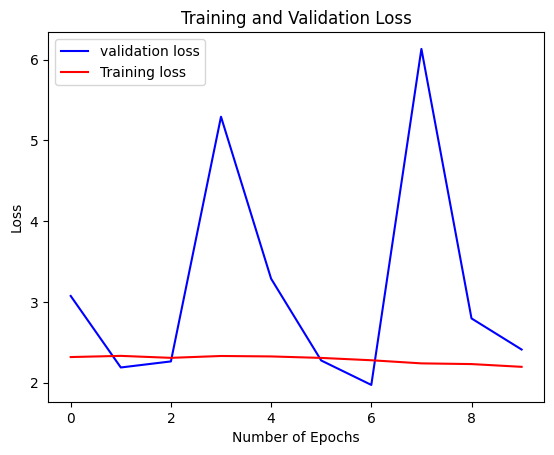

In [25]:
#Plot the loss and accuracy curves for training and validation
plt.plot(history.history['val_loss'], color='b', label="validation loss")
plt.plot(history.history['loss'], color='r', label="Training loss")
plt.title("Training and Validation Loss")
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

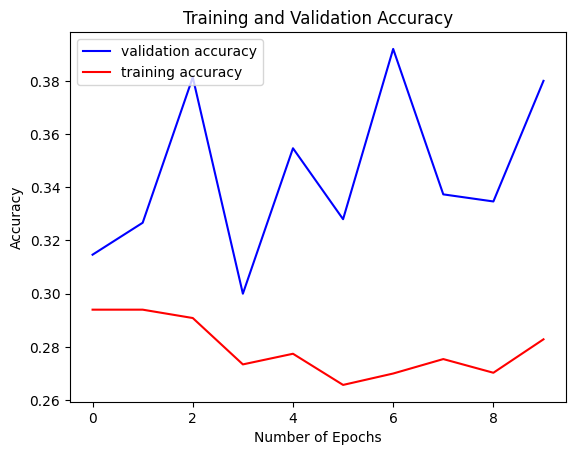

In [26]:
#Plot the loss and accuracy curves for training and validation
plt.plot(history.history['val_accuracy'], color='b', label="validation accuracy")
plt.plot(history.history['accuracy'], color='r', label="training accuracy")
plt.title("Training and Validation Accuracy")
plt.xlabel("Number of Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [28]:
# 1. We do NOT run .batch() again because test_ds was already batched in Cell 10.
#    If you run .batch() on an already batched dataset, it breaks the shape.

# 2. Make sure to use the model name you trained (model_vgg)
#    If you named your model 'model', change this back to 'model'.
y_prob = model_vgg.predict(test_ds)

# 3. Get the predicted class indices
y_pred = np.argmax(y_prob, axis=1)

# 4. Get the true labels
#    We iterate through the dataset to extract labels.
#    Since test_ds is batched, 'y' here is a batch of labels.
y_true = np.concatenate([y for x, y in test_ds], axis=0)

print("Prediction shape:", y_pred.shape)
print("True label shape:", y_true.shape)

188/188 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step
Prediction shape: (750,)
True label shape: (750,)


In [29]:
#Evaluate model
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

acc= accuracy_score(y_true, y_pred)
prec= precision_score(y_true, y_pred, average='macro')
rec= recall_score(y_true, y_pred, average='macro')
f1= f1_score(y_true, y_pred, average='macro')

print("Accuracy :", acc)
print("Precision:", prec)
print("Recall   :", rec)
print("F1-score :", f1)

Accuracy : 0.11466666666666667
Precision: 0.10691770661809352
Recall   : 0.11266465271163521
F1-score : 0.10288298764971596


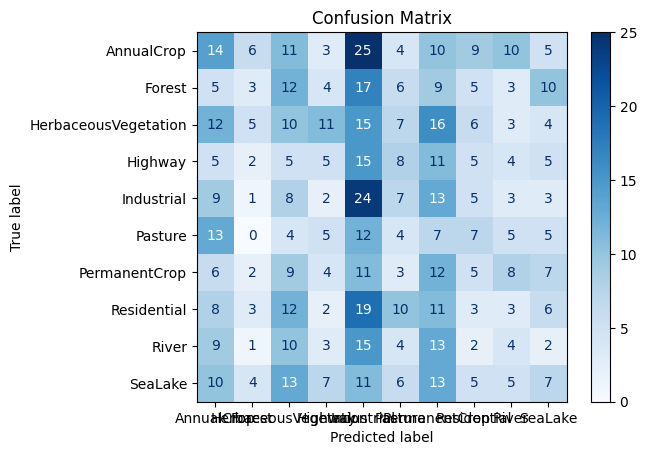

In [30]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

labels = [
    "AnnualCrop", "Forest", "HerbaceousVegetation", "Highway", "Industrial",
    "Pasture", "PermanentCrop", "Residential", "River", "SeaLake"
]

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix")
plt.show()

In [31]:
from sklearn.metrics import roc_auc_score, RocCurveDisplay
from sklearn.preprocessing import label_binarize

#y_true must be one-hot / binarized
y_true_bin = label_binarize(y_true, classes=range(10))
roc_auc_macro = roc_auc_score(y_true_bin, y_prob, multi_class="ovr", average="macro")
print("Macro-average ROC AUC:", roc_auc_macro)

Macro-average ROC AUC: 0.5134693680434765


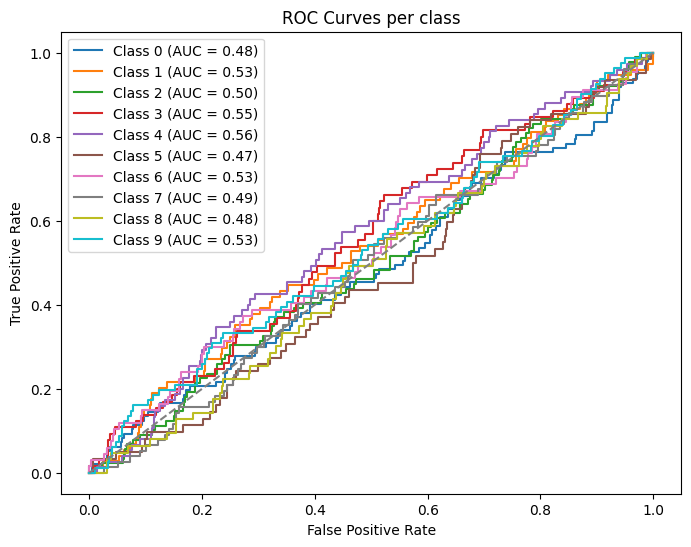

In [33]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

fpr = dict()
tpr = dict()
roc_auc = dict()  # Fixed name: changed 'rocauc' to 'roc_auc' to match the loop below

for i in range(10):
    # Fixed unpacking: Added ' _' to catch the 3rd return value (thresholds)
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_prob[:, i])

    # Calculate AUC
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plotting
plt.figure(figsize=(8,6))
for i in range(10):
    plt.plot(fpr[i], tpr[i], label=f"Class {i} (AUC = {roc_auc[i]:.2f})")

plt.plot([0,1], [0,1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves per class")
plt.legend()
plt.show()